# Qunatization

## Use
Sometimes we would like to limit the number of colors we have in an image.  
It helps in compression, and overall it sometimes looks cool


## Code

1.0

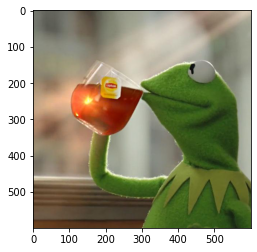

In [28]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

NUM_BITS = 8 #bit representation of colors  
N_QUANT = 4 # number of intensities
N_ITER = 100 # number of iterations
image_file="kermit.jpg"

im_mat = imread(image_file)
# Normalize
im = np.array(im_mat,dtype=np.float64)/((1<<NUM_BITS)-1)
plt.imshow(im)
im.max()

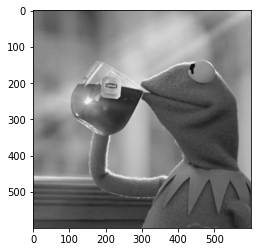

In [29]:
# transform matrix from RGB to YIQ
RGB_YIQ_MAT = np.array([[0.299, 0.587, 0.114],
                        [0.596, -0.275, -0.321],
                        [0.212, -0.523, 0.311]])

def rgb2yiq(imRGB):
    """
    Converting an RGB image to YIQ
    :param imRGB: RGB image matrix
    :return: YIQ image
    """
    yiq_trans = RGB_YIQ_MAT.T  # Transpose of the matrix
    res = np.dot(imRGB, yiq_trans)
    return res

# move to yiq
yiq=rgb2yiq(im)
y_ch = yiq[:,:,0]

# plt.hist(y_ch.flatten(),bins=256)

plt.imshow(y_ch,cmap="gray")

### Quantization error

We define the intensity of a segment i as the weighted average of the intensities in the segment with respect to it:
$$q_i = \frac{\sum_{z=z_i}^{z_{i+1}}z\cdot p(z)}{\sum_{z=z_i}^{z_{i+1}}p(z)}$$  
where z_i's are the borders of the segments (as intensity values) and p(z) are the number of reccurrences of the intensity z.

By changing $z_i$'s we want to minimize the quantization error given by:  
$$\sum_{i=0}^{k}\sum_{z=z_i}^{z_{i+1}}(q_i-z)^2p(z)$$

meaning the sum of each segment's distance from each intensity in the segment, weighted by the occurences.

In [30]:
# calculate cumulative histogram
bins = 1<<NUM_BITS
hist, bounds = np.histogram(y_ch, bins, (0, 1))
hist_cumu = np.cumsum(hist)

bins_in_segment = (hist_cumu[-1] / N_QUANT) # number of input intensities recursions for each segment
# could be non-integer but is used only for comparisons.
# indexes for multiplication
zs = np.arange(N_QUANT)
zs = np.reshape(zs*bins_in_segment,(1,N_QUANT))
# set every first intensity that is larger than the value in zs as the boreder of the segment
zs = list(np.apply_along_axis(lambda a: np.where(hist_cumu>=a)[0][0], axis=0,arr=zs))
# add last bin as border:
zs = zs if (bins-1) in zs else (zs+[bins-1])

### Iterative method for minimizing error

1. set qs with respect to zs (formula (1))
2. set new zs as the middle of the new qs
3. calculate error (formula (2))
4. repeat for a predetermined number of iterations or until error recurs

In [31]:
def get_q_vals(hist,zs):
    qs = []
    for i in range(N_QUANT):
        # according to formula (1)
        numer = np.sum(np.arange(zs[i],zs[i+1])*hist[zs[i]:zs[i+1]])
        denom = np.sum(hist[zs[i]:zs[i+1]])
        qs.append(numer/denom if numer>0 else 0)
    return qs
        
def find_err(hist,zs,qs):
    """according to formula (2)"""
    err=0
    for i in range(N_QUANT):
        err += np.sum(((qs[i]-np.arange(int(zs[i]),int(zs[i+1])))**2)*hist[int(zs[i]):int(zs[i+1])])
#         print(err)
    return err
    
errs=[]
err=0
# run for the specified number of iterations
for i in range(N_ITER):
    qs = get_q_vals(hist,zs)
#     print(qs)
    # set new zs as the middles of the intensities chosen qs
    zs = [zs[0]] + [int(round((qs[i]+qs[i+1])/2)) for i in range (len(qs)-1)]+[zs[-1]]
    errs.append(find_err(hist,zs,qs))
    if i>0 and errs[i-1] == errs[i]:
        err = errs[:-1]
        break
print(errs)
print(qs)

[56162117.02466926, 55104045.27833493, 54957949.362177834, 54917497.83748843, 54917497.83748843]
[64.21598617106234, 97.68340238849622, 140.72735729536737, 187.43497935043084]


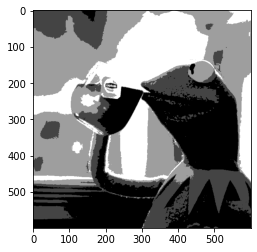

In [32]:

# create lookup table: between each of the borders the values is
# the relevant q
reps=[int(zs[i+1])-int(zs[i]) for i in range(len(zs)-1)]
reps[-1]+=1
qs = np.array(qs, dtype=np.int16)
lookup = np.repeat(qs,reps)

im_eq = lookup[(y_ch*(bins-1)).astype(np.int16)]
plt.imshow(im_eq,cmap="gray")

In [33]:
#back to RGB
def yiq2rgb(imYIQ):
    """
    Converting an YIQ image to RGB
    :param imYIQ: YIQ image matrix
    :return: RGB image
    """
    yiq_rgb_mat = np.linalg.inv(RGB_YIQ_MAT)  # Invert transform matrix
    res = np.dot(imYIQ, yiq_rgb_mat.T)
    return res

fig,[ax1,ax2] = plt.subplots(1,2,figsize = (200,200))
im_new = yiq.copy()
im_new[:,:,0] = im_eq.astype(np.float16)/((1<<NUM_BITS)-1)
im_new = yiq2rgb(im_new)
ax1.imshow(im)
ax2.imshow(im_new)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
